In [32]:
!pip install rpy2 --quiet
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
%%R
required_pkgs <- c(
  "tidyverse",
  "ggplot2",
  "pwr",
  "effectsize",
  "janitor",
  "rmarkdown"
)

install_if_missing <- function(pkg) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, repos = "https://cloud.r-project.org")
    library(pkg, character.only = TRUE)
  }
}

invisible(lapply(required_pkgs, install_if_missing))

In [34]:
%%R
# Load the available customers-100000.csv file
data_path <- "experimental_data.csv"

data <- read_csv(data_path) %>%
  clean_names()

colnames(data)

glimpse(data)
# After inspecting colnames(data), you can uncomment and adjust the mutate call:
# data <- data %>%
#  mutate(
#    group = as.factor(YOUR_ACTUAL_GROUP_COLUMN_NAME),
#    treatment = as.factor(YOUR_ACTUAL_TREATMENT_COLUMN_NAME)
#  )


Rows: 90 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): group
dbl (2): subject_id, response

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 90
Columns: 3
$ subject_id <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …
$ group      <chr> "Control", "Control", "Control", "Control", "Control", "Con…
$ response   <dbl> 48.5, 50.1, 49.3, 51.0, 47.8, 52.2, 50.6, 49.9, 48.7, 51.4,…


In [35]:
%%R
summary_table <- data %>%
  group_by(group) %>%
  summarise(
    mean = mean(response),
    sd = sd(response),
    n = n(),
    .groups = "drop"
  )

summary_table

# A tibble: 3 × 4
  group        mean    sd     n
  <chr>       <dbl> <dbl> <int>
1 Control      50.0 1.36     30
2 Treatment_A  55.3 0.849    30
3 Treatment_B  60.4 0.931    30


In [36]:
%%R
data_ttest <- data %>% filter(group %in% c("Control", "Treatment_A"))

data_ttest$group <- droplevels(as.factor(data_ttest$group))

t_test <- t.test(response ~ group, data = data_ttest)

t_effect <- cohens_d(response ~ group, data = data_ttest)

list(
  t_test_result = t_test,
  effect_size = t_effect
)

$t_test_result

	Welch Two Sample t-test

data:  response by group
t = -18.276, df = 48.575, p-value < 2.2e-16
alternative hypothesis: true difference in means between group Control and group Treatment_A is not equal to 0
95 percent confidence interval:
 -5.945796 -4.767537
sample estimates:
    mean in group Control mean in group Treatment_A 
                 49.96333                  55.32000 


$effect_size
Cohen's d |         95% CI
--------------------------
-4.72     | [-5.71, -3.72]

- Estimated using pooled SD.


In [37]:
%%R
anova_model <- aov(response ~ group, data = data)
anova_summary <- summary(anova_model)

anova_effect <- eta_squared(anova_model)

list(
  anova = anova_summary,
  effect_size = anova_effect
)

$anova
            Df Sum Sq Mean Sq F value Pr(>F)    
group        2 1640.5   820.2   714.4 <2e-16 ***
Residuals   87   99.9     1.1                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$effect_size
# Effect Size for ANOVA

Parameter | Eta2 |       95% CI
-------------------------------
group     | 0.94 | [0.92, 1.00]

- One-sided CIs: upper bound fixed at [1.00].


For one-way between subjects designs, partial eta squared is equivalent
  to eta squared. Returning eta squared.


In [38]:
%%R
# Power based on observed effect size
t_power <- pwr.t.test(
  d = t_effect$Cohens_d,
  sig.level = 0.05,
  power = 0.80,
  type = "two.sample"
)

anova_power <- pwr.anova.test(
  k = nlevels(as.factor(data$group)), # Explicitly convert to factor
  f = sqrt(anova_effect$Eta2[1]),
  sig.level = 0.05,
  power = 0.80
)

list(
  t_test_power = t_power,
  anova_power = anova_power
)

$t_test_power

     Two-sample t test power calculation 

              n = 2.182234
              d = 4.718879
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


$anova_power

     Balanced one-way analysis of variance power calculation 

              k = 3
              n = 4.569347
              f = 0.9708789
      sig.level = 0.05
          power = 0.8

NOTE: n is number in each group




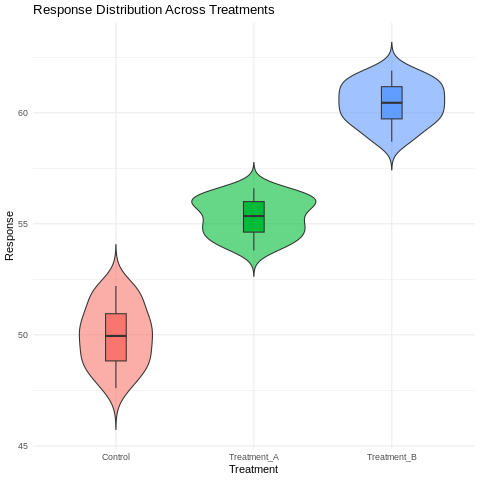

In [39]:
%%R
ttest_plot <- ggplot(data, aes(group, response, fill = group)) +
  geom_boxplot(alpha = 0.7) +
  stat_summary(fun = mean, geom = "point", size = 3) +
  labs(
    title = "Two-Sample Comparison",
    subtitle = "Mean Overlay with Distribution",
    x = "Group",
    y = "Response"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

anova_plot <- ggplot(data, aes(group, response, fill = group)) + # Changed 'treatment' to 'group'
  geom_violin(trim = FALSE, alpha = 0.6) +
  geom_boxplot(width = 0.15, outlier.shape = NA) +
  labs(
    title = "Response Distribution Across Treatments",
    x = "Treatment",
    y = "Response"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

ttest_plot
anova_plot

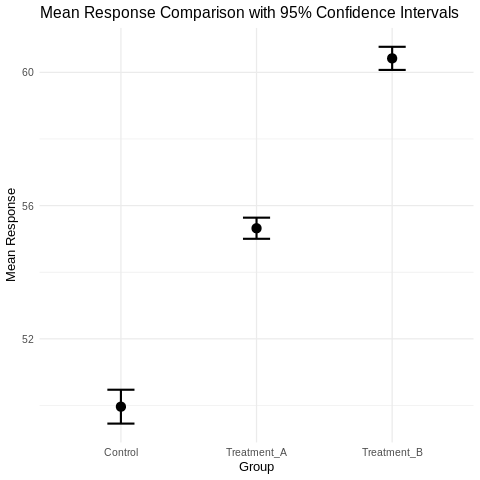

In [40]:
%%R
summary_stats <- data %>%
  group_by(group) %>%
  summarise(
    mean = mean(response),
    sd = sd(response),
    n = n(),
    se = sd / sqrt(n),
    ci_lower = mean - qt(0.975, df = n - 1) * se,
    ci_upper = mean + qt(0.975, df = n - 1) * se
  )
  ggplot(summary_stats, aes(x = group, y = mean)) +
  geom_point(size = 4) +
  geom_errorbar(
    aes(ymin = ci_lower, ymax = ci_upper),
    width = 0.2,
    linewidth = 1
  ) +
  labs(
    title = "Mean Response Comparison with 95% Confidence Intervals",
    x = "Group",
    y = "Mean Response"
  ) +
  theme_minimal(base_size = 13)

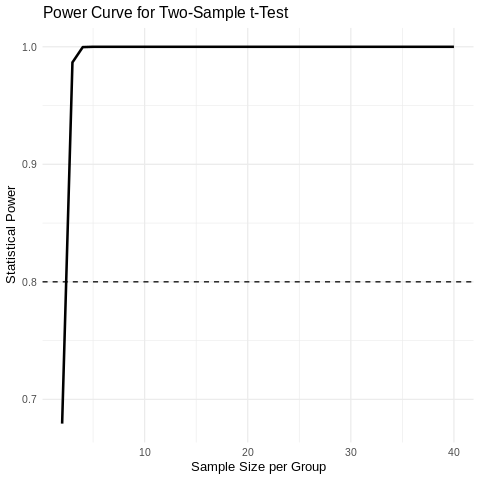

In [41]:
%%R
# Load library
library(pwr)

# Define range of sample sizes per group
sample_sizes <- seq(2, 40, by = 1)

# Compute power for each sample size
power_ttest <- data.frame(
  n = sample_sizes,
  power = sapply(sample_sizes, function(n) {
    pwr.t.test(
      n = n,
      d = 4.72,
      sig.level = 0.05,
      type = "two.sample",
      alternative = "two.sided"
    )$power
  })
)

# Plot power curve
ggplot(power_ttest, aes(x = n, y = power)) +
  geom_line(linewidth = 1.2) +
  geom_hline(yintercept = 0.8, linetype = "dashed") +
  labs(
    title = "Power Curve for Two-Sample t-Test",
    x = "Sample Size per Group",
    y = "Statistical Power"
  ) +
  theme_minimal(base_size = 13)

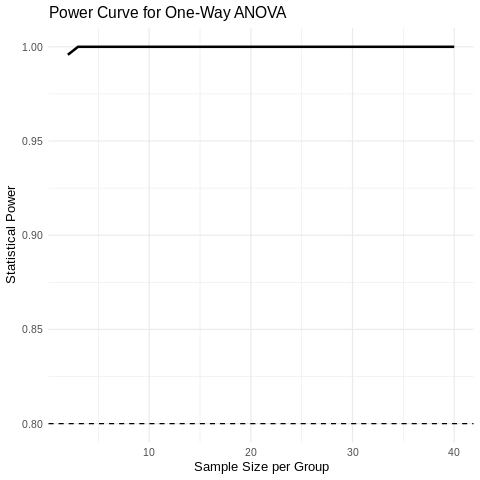

In [42]:
ch%%R
# Convert eta-squared to Cohen's f
eta_sq <- 0.94
f_value <- sqrt(eta_sq / (1 - eta_sq))

# Define sample sizes per group
sample_sizes <- seq(2, 40, by = 1)

# Compute power for ANOVA
power_anova <- data.frame(
  n = sample_sizes,
  power = sapply(sample_sizes, function(n) {
    pwr.anova.test(
      k = 3,
      n = n,
      f = f_value,
      sig.level = 0.05
    )$power
  })
)

# Plot power curve
ggplot(power_anova, aes(x = n, y = power)) +
  geom_line(linewidth = 1.2) +
  geom_hline(yintercept = 0.8, linetype = "dashed") +
  labs(
    title = "Power Curve for One-Way ANOVA",
    x = "Sample Size per Group",
    y = "Statistical Power"
  ) +
  theme_minimal(base_size = 13)